In [2]:
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime, timedelta
import json
from abc import ABCMeta, abstractmethod
import boto3
import snowflake.connector
from io import StringIO
import logging 

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

from utils import *

class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model    

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError

        
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )
        return ctx

    
def run_query(querystr, ctx):
    cursor_list = ctx.execute_string(
        querystr
        )
    df = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
    df.columns= df.columns.str.lower()
    return df

import plotly.express as px
def get_simple_plot(df_plt, x, y, grpby, text, title=''):
    if title=='':
        title = f'{y} vs {x}'
    df_plt[grpby] = df_plt[grpby].astype(str)
    fig = px.line(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  color=grpby, 
                  hover_data=[text],
                  width=800, height=400)
    fig.show()
    return 


## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"
key_path = 'cost_allocation/dev'

INFO:root:Starting Notebook


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.13, Platform: Linux-4.14.322-170.535.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.connection:Setting use_openssl_only mode to False


In [3]:
# query='''
# select 
# cast(DATE_TRUNC('MONTH',cycle_expire_date) as date) as month
# ,sub_month
# ,is_cancel
# , count(distinct hbo_uuid) as subscriber_count
# from max_dev.workspace.user_retain_churn_list_test 
# where cast(cycle_start_date as date) <'2023-01-01'
# and cast(cycle_expire_date as date) >='2022-01-01'
# group by month, sub_month, is_cancel 
# '''

query='''
with pvc as (
select
    wholesale_user_activation.user_id,
    hbo_uuid,
    affiliate_code
from max_prod.bi_analytics.wholesale_user_activation
    left join max_prod.bi_analytics.dimension_user
        on wholesale_user_activation.user_id = dimension_user.user_id
    left join max_prod.core.geo_map
        on wholesale_user_activation.country_code = geo_map.country_iso_code
where
    wholesale_user_activation.country_code = 'US'
    and geo_map.territory = 'HBO MAX DOMESTIC'
    and geo_map.region = 'NORTH AMERICA'
    and affiliate_code = 'amazon_hbonow'
    and convert_timezone('UTC', 'America/Los_Angeles', wholesale_user_activation.first_auth_time_utc::timestamp) >= '2020-11-17'
)
select
date(date_trunc('Month', c.cycle_expire_date)) as month
, sub_month
, c.is_cancel
  ,count(distinct a.provider_user_id) as subscriber_count
from max_dev.workspace.user_retain_churn_list_test c
left join  max_prod.bi_analytics.fact_common_receipt a
    on c.hurley_user_id=a.hurley_user_id
    and a.subscription_start_date = c.cycle_start_date
left join pvc 
    on pvc.hbo_uuid = c.hbo_uuid
where cast(cycle_start_date as date) <'2023-01-01'
and cast(cycle_expire_date as date) >='2022-01-01'
and (a.signup_offer is NULL or a.signup_offer='no_free_trial')
and affiliate_code is NULL
group by month, sub_month, c.is_cancel
order by sub_month DESC  
'''


# df_churn =  run_query(query, ctx)
# df_churn=df_churn.sort_values(by=['month','sub_month','is_cancel'])
# df_churn['month'] = pd.to_datetime(df_churn.month)
# df_churn = df_churn[(df_churn.sub_month<=24) & (df_churn.month>='2022-01-01') & (df_churn.month<'2023-01-01')]
df_churn = Utils.read_csv_s3(input_bucket, key_path, 'df_churn_2309.csv')


df_churnp = df_churn.pivot(index=['month','sub_month'], columns='is_cancel', values='subscriber_count').reset_index()
df_churnp = df_churnp.rename(columns={True: 'is_cancel_true', False: 'is_cancel_false'})
df_churnp=df_churnp.reset_index()


df_churnp['total'] = df_churnp['is_cancel_false'] +  df_churnp['is_cancel_true']
df_churnp['churn_rate'] = df_churnp['is_cancel_true']/df_churnp['total']
df_churnp['tenure_grp'] = 0
df_churnp['tenure_grp'] = np.where(df_churnp['sub_month']<=3, '1-3', df_churnp['tenure_grp'])
df_churnp['tenure_grp'] = np.where((df_churnp['sub_month']>3) & (df_churnp['sub_month']<=6), '4-6', df_churnp['tenure_grp'])
df_churnp['tenure_grp'] = np.where((df_churnp['sub_month']>6) & (df_churnp['sub_month']<=12), '6-12', df_churnp['tenure_grp'])
df_churnp['tenure_grp'] = np.where((df_churnp['sub_month']>12), '>12', df_churnp['tenure_grp'])
df_churnp['composition'] = df_churnp['total'] / df_churnp.groupby('month')['total'].transform('sum')
display(df_churnp.head())

df_churnpm = df_churnp[(df_churnp.sub_month<=24)].groupby(by=['month']).sum().reset_index()
df_churnpm['churn_rate'] = df_churnpm['is_cancel_true']/df_churnpm['total']
display(df_churnpm.head())

df_churnpt = df_churnp.copy()
df_churnpt['weighted_tenure'] = df_churnpt['sub_month'] *df_churnpt['total'] 
df_churnpt = df_churnpt.groupby(by=['month'])

# Utils.to_csv_s3(df_churn, input_bucket, key_path, 'df_churn_2309.csv')


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/df_churn_2309.csv
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


is_cancel,index,month,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,tenure_grp,composition
0,0,2022-01-01,1,1000221,330175,1330396,0.248178,1-3,0.127524
1,1,2022-01-01,2,495093,91248,586341,0.155623,1-3,0.056203
2,2,2022-01-01,3,552589,76743,629332,0.121944,1-3,0.060324
3,3,2022-01-01,4,267510,32818,300328,0.109274,4-6,0.028788
4,4,2022-01-01,5,455599,48277,503876,0.095811,4-6,0.048299


is_cancel,month,index,sub_month,is_cancel_false,is_cancel_true,total,churn_rate,composition
0,2022-01-01,276,300,9509743,922747,10432490,0.088449,1.0
1,2022-02-01,852,300,9361360,787995,10149355,0.077640,1.0
2,2022-03-01,1428,300,9575767,801067,10376834,0.077198,1.0
3,2022-04-01,2004,300,9413842,766149,10179991,0.075260,1.0
4,2022-05-01,2580,300,9412058,718541,10130599,0.070928,1.0


In [66]:
df_hv_decay.head()

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month
184,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-01,184,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
185,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-02,185,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
186,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-03,186,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
187,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-04,187,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
188,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-05,188,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01


In [4]:
## Get retention metric, find out .. 
df_hv_decay = Utils.read_csv_s3("hbo-outbound-datascience-content-dev", "title_hours_viewed_retention", 'historcial_and_future_daily_monthly_retention_value_2023-09-28.csv')
display(df_hv_decay.head()) 
df_hv_decay = df_hv_decay[(df_hv_decay.request_date>='2022-01-01')]
df_hv_decay['change_in_churn'] = df_hv_decay['change_in_churn_prediction']


df_retention = df_hv_decay.groupby(by=['date_month']).sum().reset_index()
df_retention

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-outbound-datascience-content-dev/title_hours_viewed_retention/historcial_and_future_daily_monthly_retention_value_2023-09-28.csv


,title_name,title_id,season_number,request_date,days_on_hbo_max,change_in_churn_prediction,name_number,genre,medal,offering_start_date,churn_per_hr_person,change_in_churn_60d_prediction,asset_run_time_hours,pred_type,date_month
0,Last Week Tonight with John Oliver,GVU2cCgUFTYNJjhsJATuH,7.0,2020-05-27,0,-0.000112,0,other,Bronze,2020-05-27,-0.011155,-0.000208,15.22693,historical,2020-05
1,Last Week Tonight with John Oliver,GVU2cCgUFTYNJjhsJATuH,7.0,2020-05-28,1,-0.000108,0,other,Bronze,2020-05-27,-0.011155,-0.000208,15.22693,historical,2020-05
2,Last Week Tonight with John Oliver,GVU2cCgUFTYNJjhsJATuH,7.0,2020-05-29,2,-0.000105,0,other,Bronze,2020-05-27,-0.011155,-0.000208,15.22693,historical,2020-05
3,Last Week Tonight with John Oliver,GVU2cCgUFTYNJjhsJATuH,7.0,2020-05-30,3,-0.000102,0,other,Bronze,2020-05-27,-0.011155,-0.000208,15.22693,historical,2020-05
4,Last Week Tonight with John Oliver,GVU2cCgUFTYNJjhsJATuH,7.0,2020-05-31,4,-0.000098,0,other,Bronze,2020-05-27,-0.011155,-0.000208,15.22693,historical,2020-05


,date_month,season_number,days_on_hbo_max,change_in_churn_prediction,name_number,churn_per_hr_person,change_in_churn_60d_prediction,asset_run_time_hours,change_in_churn
0,2022-01,7590.0,1005466,-0.154520,1654038,-85.144770,-3.468585,19098.320635,-0.154520
1,2022-02,7656.0,966920,-0.131879,1550303,-80.832119,-3.366402,17917.717247,-0.131879
2,2022-03,8562.0,1106155,-0.136988,1733436,-90.327385,-3.961095,20152.528131,-0.136988
3,2022-04,8254.0,1127193,-0.131168,1682881,-86.946388,-3.909640,19690.024660,-0.131168
4,2022-05,8750.0,1217297,-0.125766,1751371,-87.360517,-4.126270,20684.877480,-0.125766
5,2022-06,8356.0,1200778,-0.116612,1666271,-81.074931,-3.725606,19468.658949,-0.116612
6,2022-07,7892.0,1278843,-0.104218,1727371,-80.579347,-3.432428,19865.587108,-0.104218
7,2022-08,7927.0,1307462,-0.099181,1595029,-74.000898,-2.932764,19582.438721,-0.099181
8,2022-09,7612.0,1298332,-0.113945,1493835,-67.277963,-2.658996,18574.789189,-0.113945
9,2022-10,7746.0,1364934,-0.092935,1486788,-65.962632,-2.479768,18343.358046,-0.092935


In [5]:
### Decayed result total 

# Jan:  Euphoria, peacemaker 
# Feb: Euphoria, peacemaker
# Mar: Free guy, king's man, euphoria
# Apr


pd.set_option('display.max_rows', None)
df_p = df_hv_decay.groupby(by=['date_month','title_name','offering_start_date','medal','genre']).agg({'change_in_churn':'sum',  
                                                                                                                      'asset_run_time_hours':'mean', 
#                                                                                                                       'average_hours_viewed_60d':'mean', 
                                                                                                                      'churn_per_hr_person':'mean'
                                                                                                                     }).reset_index()

### Annual ranking 
grpby = ['title_name', 'offering_start_date','medal','genre']
key_col = ['change_in_churn', 'asset_run_time_hours','churn_per_hr_person']
agg_dic = {'change_in_churn':'sum', 
           'asset_run_time_hours':'mean'
#            'average_hours_viewed_60d':'mean'
          ,'churn_per_hr_person':'mean'}
display(df_p[grpby+key_col].groupby(by=grpby).agg(agg_dic).reset_index().sort_values(by=['change_in_churn'],ascending=True).head(20))


# ### Monthly ranking 
grpby = ['date_month']
key_col = ['title_name', 'offering_start_date','medal','genre', 'change_in_churn', 'asset_run_time_hours']

df_p = df_p.sort_values(by=['date_month','change_in_churn'], ascending=True)
display(df_p[grpby+key_col].groupby(by=grpby).head(10).reset_index())



,title_name,offering_start_date,medal,genre,change_in_churn,asset_run_time_hours,churn_per_hr_person
868,The Big Bang Theory,2020-05-27,Bronze,comedy,-1.570260,7.648994,-0.015914
286,Friends,2020-05-27,Bronze,comedy,-1.561369,8.725240,-0.015914
928,The Sopranos,2020-05-27,Bronze,drama,-0.477461,12.695040,-0.008210
301,Game of Thrones,2020-05-27,Bronze,drama,-0.391495,8.582218,-0.008210
676,Pretty Little Liars,2020-05-27,Bronze,drama,-0.272613,16.682074,-0.008210
199,Curb Your Enthusiasm,2021-10-25,Silver,comedy,-0.240625,6.144163,-0.019812
23,2026 TBD DOCUMENTARIES,2026-05-01,Gold,other,-0.120653,37.000000,-0.042203
198,Curb Your Enthusiasm,2020-05-27,Bronze,comedy,-0.092213,6.174995,-0.015914
22,2025 TBD SPECIALS,2025-05-01,Gold,other,-0.081523,25.000000,-0.042203
29,2026 TBD SPECIALS,2026-05-01,Gold,other,-0.081523,25.000000,-0.042203


,index,date_month,title_name,offering_start_date,medal,genre,change_in_churn,asset_run_time_hours
0,24,2022-01,Euphoria,2022-01-10,Platinum,drama,-0.022589,7.819440
1,88,2022-01,The Big Bang Theory,2020-05-27,Bronze,comedy,-0.018191,7.648994
2,28,2022-01,Friends,2020-05-27,Bronze,comedy,-0.018088,8.725240
3,71,2022-01,Peacemaker,2022-01-13,Platinum,drama,-0.009440,5.662218
4,102,2022-01,The Last Duel,2022-01-14,Gold,drama,-0.008521,2.544444
5,38,2022-01,Hitman's Wife's Bodyguard,2022-01-07,Gold,comedy,-0.006735,1.764722
6,36,2022-01,Harry Potter 20th Anniversary: Return to Hogwarts,2022-01-01,Platinum,other,-0.006031,1.680555
7,111,2022-01,The Sopranos,2020-05-27,Bronze,drama,-0.005531,12.695040
8,30,2022-01,Game of Thrones,2020-05-27,Bronze,drama,-0.004535,8.582218
9,85,2022-01,Station Eleven,2021-12-16,Gold,drama,-0.003430,8.456384


In [86]:
df_hv_decay.head()

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month
184,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-01,184,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
185,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-02,185,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
186,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-03,186,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
187,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-04,187,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01
188,Mighty Morphin Power Rangers: The Movie,GV0SzrAzOp5eatgEAAAAj,0,other,Bronze,2021-07-01,2022-01-05,188,-0.000001,0.00597,-0.033936,-0.000203,1.593888,2022-01


In [14]:
df_p = df_hv_decay.groupby(by=['date_month','title_name','season_number','offering_start_date','medal','genre']).agg({'change_in_churn':'sum',  
                                                                                                                      'asset_run_time_hours':'mean', 
#                                                                                                                       'average_hours_viewed_60d':'mean', 
                                                                                                                      'churn_per_hr_person':'mean'
                                                                                                                     }).reset_index()

### Annual new release ranking 
grpby = ['title_name','season_number','offering_start_date','medal','genre']
key_col = ['change_in_churn', 'asset_run_time_hours','churn_per_hr_person']
agg_dic = {'change_in_churn':'sum', 
           'asset_run_time_hours':'mean',
#            'average_hours_viewed_60d':'mean',
          'churn_per_hr_person':'mean'}
df_new = df_p[df_p.offering_start_date>='2022-01-01']
display(df_new[grpby+key_col].groupby(by=grpby).agg(agg_dic).reset_index().sort_values(by=['change_in_churn'],ascending=True).head(20))

# ### Monthly new release ranking 
grpby = ['date_month']
key_col = ['title_name','season_number','offering_start_date','medal','genre', 'change_in_churn', 'asset_run_time_hours']

df_p = df_p.sort_values(by=['date_month','change_in_churn'], ascending=True)
df_new = df_p[df_p.offering_start_date>='2022-01-01']
display(df_new[grpby+key_col].groupby(by=grpby).head(10).reset_index())




,title_name,season_number,offering_start_date,medal,genre,change_in_churn,asset_run_time_hours,churn_per_hr_person
139,Euphoria,2.0,2022-01-10,Platinum,drama,-0.053000,7.819440,-0.018346
246,HOUSE OF THE DRAGON S3,3.0,2026-05-01,Platinum,drama,-0.042510,10.000000,-0.018346
447,SUCCESSION S4,4.0,2023-03-01,Platinum,drama,-0.039746,10.000000,-0.018346
13,2025 TBD HOUR S1,1.0,2025-06-01,Platinum,drama,-0.039746,10.000000,-0.018346
263,House of the Dragon,1.0,2022-08-22,Platinum,drama,-0.036782,10.259162,-0.018346
133,EUPHORIA S3,3.0,2025-01-01,Platinum,drama,-0.034008,8.000000,-0.018346
134,EUPHORIA S4 / TBD,4.0,2026-10-01,Platinum,drama,-0.034008,8.000000,-0.018346
245,HOUSE OF THE DRAGON S2,2.0,2024-06-01,Platinum,drama,-0.034008,8.000000,-0.018346
599,WALLER (LS),1.0,2025-03-01,Platinum,drama,-0.031796,8.000000,-0.018346
238,HARRY POTTER SERIES S1 / TBD,1.0,2025-11-01,Platinum,drama,-0.031796,8.000000,-0.018346


,index,date_month,title_name,season_number,offering_start_date,medal,genre,change_in_churn,asset_run_time_hours
0,24,2022-01,Euphoria,2.0,2022-01-10,Platinum,drama,-0.022589,7.819440
1,87,2022-01,Peacemaker,1.0,2022-01-13,Platinum,drama,-0.009440,5.662218
2,130,2022-01,The Last Duel,0.0,2022-01-14,Gold,drama,-0.008521,2.544444
3,54,2022-01,Hitman's Wife's Bodyguard,0.0,2022-01-07,Gold,comedy,-0.006735,1.764722
4,52,2022-01,Harry Potter 20th Anniversary: Return to Hogwarts,0.0,2022-01-01,Platinum,other,-0.006031,1.680555
5,84,2022-01,Nobody,0.0,2022-01-21,Gold,action,-0.002923,1.507777
6,137,2022-01,The Righteous Gemstones,2.0,2022-01-10,Silver,comedy,-0.002682,5.394163
7,124,2022-01,The Fallout,0.0,2022-01-27,Gold,drama,-0.001787,1.567500
8,125,2022-01,The Gilded Age,1.0,2022-01-25,Gold,drama,-0.001670,8.204439
9,10,2022-01,Annabelle Comes Home,0.0,2022-01-01,Bronze,other,-0.001328,1.719444


In [28]:
### First 60 days 
df_hv_decayt = df_hv_decay.drop_duplicates(subset=['title_name','season_number'])
df_hv_decayt['churn_impact_60d_tot'] = df_hv_decayt['change_in_churn_60d'] * df_hv_decayt['asset_run_time_hours']
df_hv_decayt['average_hours_viewed_60d_tot'] = df_hv_decayt['average_hours_viewed_60d'] * df_hv_decayt['asset_run_time_hours']


col = ['title_name','season_number','genre','medal','offering_start_date','average_hours_viewed_60d','average_hours_viewed_60d_tot','churn_per_hr_person','change_in_churn_60d','churn_impact_60d_tot','asset_run_time_hours']
display(df_hv_decayt[df_hv_decayt.offering_start_date>='2022-01-01'].sort_values(by=['average_hours_viewed_60d_tot'], ascending=False)[col].head(20))
display(df_hv_decayt.sort_values(by=['churn_impact_60d_tot'], ascending=True)[col].head(10))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title_name,season_number,genre,medal,offering_start_date,average_hours_viewed_60d,average_hours_viewed_60d_tot,churn_per_hr_person,change_in_churn_60d,churn_impact_60d_tot,asset_run_time_hours
908317,House of the Dragon,1,drama,Platinum,2022-08-22,0.342126,3.509927,-0.018346,-0.006277,-0.064394,10.259162
907488,Euphoria,2,drama,Platinum,2022-01-10,0.237642,1.858230,-0.018346,-0.004360,-0.034092,7.819440
933005,The Batman,0,action,Platinum,2022-04-18,0.431182,1.266237,-0.028358,-0.012228,-0.035908,2.936666
881242,The White Lotus,2,drama,Gold,2022-10-31,0.162995,1.174062,-0.012750,-0.002078,-0.014969,7.203053
907904,Peacemaker,1,drama,Platinum,2022-01-13,0.158175,0.895619,-0.018346,-0.002902,-0.016431,5.662218
933599,Black Adam,0,action,Platinum,2022-12-16,0.312785,0.650766,-0.028358,-0.008870,-0.018455,2.080555
883168,The Staircase,1,drama,Gold,2022-05-05,0.073366,0.624503,-0.012750,-0.000935,-0.007962,8.512218
882808,Winning Time: The Rise of the Lakers Dynasty,1,drama,Gold,2022-03-07,0.063398,0.599759,-0.012750,-0.000808,-0.007647,9.460273
881966,The Gilded Age,1,drama,Gold,2022-01-25,0.067300,0.552160,-0.012750,-0.000858,-0.007040,8.204439
933323,Fantastic Beasts: The Secrets of Dumbledore,0,action,Platinum,2022-05-30,0.220275,0.523703,-0.028358,-0.006247,-0.014851,2.377500


,title_name,season_number,genre,medal,offering_start_date,average_hours_viewed_60d,average_hours_viewed_60d_tot,churn_per_hr_person,change_in_churn_60d,churn_impact_60d_tot,asset_run_time_hours
908317,House of the Dragon,1,drama,Platinum,2022-08-22,0.342126,3.509927,-0.018346,-0.006277,-0.064394,10.259162
944456,Zack Snyder's Justice League,0,drama,Platinum,2021-03-18,0.494117,1.945861,-0.024174,-0.011945,-0.047040,3.938055
929753,Wonder Woman 1984,0,action,Platinum,2020-12-25,0.616159,1.520029,-0.028358,-0.017473,-0.043105,2.466944
930454,Godzilla vs. Kong,0,action,Platinum,2021-03-31,0.781610,1.453795,-0.028358,-0.022165,-0.041227,1.860000
933005,The Batman,0,action,Platinum,2022-04-18,0.431182,1.266237,-0.028358,-0.012228,-0.035908,2.936666
931132,Mortal Kombat,0,action,Platinum,2021-04-23,0.676640,1.223779,-0.028358,-0.019188,-0.034704,1.808611
907488,Euphoria,2,drama,Platinum,2022-01-10,0.237642,1.858230,-0.018346,-0.004360,-0.034092,7.819440
918446,Space Jam: A New Legacy,0,other,Silver,2021-07-16,0.461859,0.870732,-0.038234,-0.017659,-0.033292,1.885277
931706,The Suicide Squad,0,action,Platinum,2021-08-05,0.525170,1.140495,-0.028358,-0.014893,-0.032342,2.171666
927985,The Little Things,0,drama,Silver,2021-01-29,0.333148,0.699982,-0.030182,-0.010055,-0.021127,2.101111


In [21]:
c/(hr_viewed/person) * (hour_viewed)/(person*title_hour) = 

-0.00051401989

In [37]:
df_hv_decayt[df_hv_decayt.title_name.str.contains('House of the Dragon')]

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month,churn_impact_tot,average_hours_viewed_60d_tot
587222,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,drama,Platinum,2022-08-22,2022-08-22,0,-0.001777,0.167612,-0.018346,-0.003075,10.259162,2022-08,-0.031548,1.719563


In [35]:
df_hv_decayt[df_hv_decayt.title_name.str.contains('White Lotus')]

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month,churn_impact_tot,average_hours_viewed_60d_tot
562635,The White Lotus,GYLD3_ArixL1sggEAAAHk,1,drama,Gold,2021-07-12,2022-01-01,173,-0.000007,0.028095,-0.01275,-0.000358,5.740552,2022-01,-0.002056,0.161280
563060,The White Lotus,GYLD3_ArixL1sggEAAAHk,2,drama,Gold,2022-10-31,2022-10-31,0,-0.000278,0.053677,-0.01275,-0.000684,7.203053,2022-10,-0.004930,0.386639


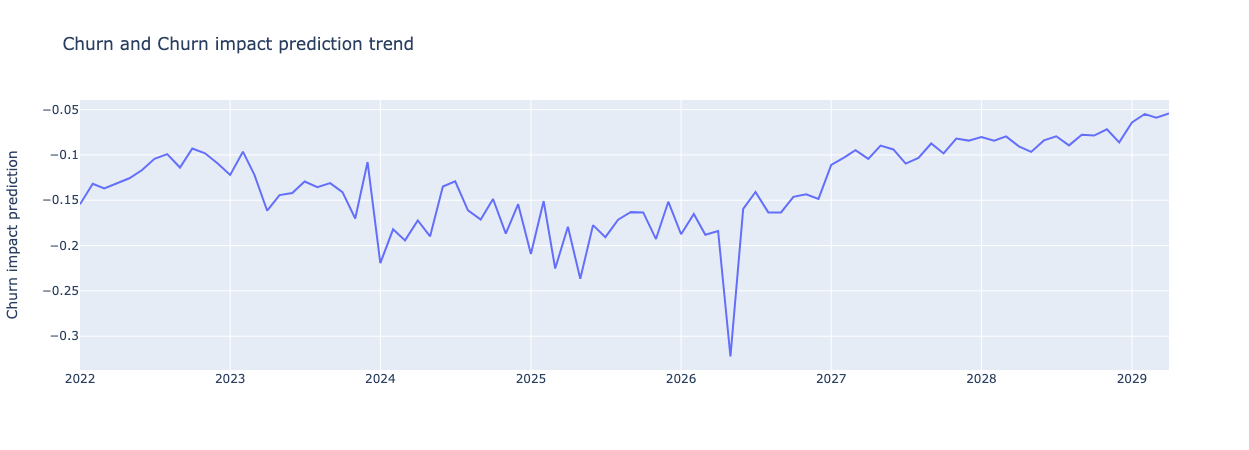

In [8]:
import plotly.graph_objects as go


fig = go.Figure()

# fig.add_trace(go.Scatter(x=df_churnpm['month'], y=df_churnpm['churn_rate'], mode='lines', name='Churn', yaxis='y'))
fig.add_trace(go.Scatter(x=df_retention['date_month'], y=df_retention['change_in_churn'], mode='lines', name='Churn impact pred', yaxis='y'))

fig.update_layout(
#     yaxis=dict(title='Churn'),
    yaxis=dict(title='Churn impact prediction')
)

fig.update_layout(title='Churn and Churn impact prediction trend')
fig.show()



# fig = go.Figure()

# fig.add_trace(go.Scatter(x=df_churnpm['month'], y=df_churnpm['churn_rate'], mode='lines', name='Churn', yaxis='y'))
# fig.add_trace(go.Scatter(x=df_retention['date_month'], y=df_retention['average_hours_viewed_decay'], mode='lines', name='hours_viewed', yaxis='y2'))

# fig.update_layout(
#     yaxis=dict(title='Churn'),
#     yaxis2=dict(title='hours_viewed', overlaying='y', side='right')
# )

# fig.update_layout(title='Churn and hours_viewed trend')
# fig.show()



# fig = go.Figure()

# fig.add_trace(go.Scatter(x=df_retention['date_month'], y=-df_retention['change_in_churn'], mode='lines', name='Churn impact pred', yaxis='y'))
# fig.add_trace(go.Scatter(x=df_retention['date_month'], y=df_retention['average_hours_viewed_decay'], mode='lines', name='hours_viewed', yaxis='y2'))

# fig.update_layout(
#     yaxis=dict(title='Churn impact pred'),
#     yaxis2=dict(title='hours_viewed', overlaying='y', side='right')
# )

# fig.update_layout(title='Churn impact pred and hours_viewed trend')
# fig.show()